In [253]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCRCatalogs import GCRQuery
import numpy as np
from matplotlib.patches import Rectangle
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
import sys
import os
import shutil
import pickle
import healpy as hp
import h5py
import pandas as pd

###clevar
import clevar
from clevar import ClCatalog
from clevar.match import ProximityMatch
from clevar.match_metrics import scaling
from clevar.match_metrics import recovery
from clevar.match_metrics import distances
from clevar.match import get_matched_pairs
from clevar.match import output_matched_catalog

In [219]:
print(cat.list_all_quantities())
#print(amico_data.colnames)

['sed_1000_246', 'sed_3812_236_disk_no_host_extinction', 'mag_i_lsst', 'mag_g_sdss', 'sed_4565_283_bulge', 'mag_true_g_lsst', 'mag_true_y', 'sed_9395_583', 'sed_7843_486_disk', 'ra', 'sed_6548_406_no_host_extinction', 'sed_4848_300_disk_no_host_extinction', 'sed_7385_458_no_host_extinction', 'sed_1933_474_bulge_no_host_extinction', 'mag_true_y_lsst_no_host_extinction', 'sed_1933_474_no_host_extinction', 'R_v', 'sed_4565_283_disk_no_host_extinction', 'sed_9978_1489_no_host_extinction', 'sed_8846_549_disk_no_host_extinction', 'position_angle_true', 'mag_true_r_sdss', 'sed_6166_382_bulge_no_host_extinction', 'Mag_true_y_lsst_z0_no_host_extinction', 'sed_7385_458_disk', 'convergence', 'velocity_z', 'position_x', 'sed_5148_319_no_host_extinction', 'bulge_to_total_ratio_i', 'sed_7843_486_disk_no_host_extinction', 'sed_13177_1966_bulge', 'halo_id', 'sed_7385_458_bulge', 'sed_2998_186_bulge_no_host_extinction', 'sed_4299_266_disk', 'sed_6548_406_disk_no_host_extinction', 'sed_3812_236_no_host_

In [221]:
cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
cosmodc2_data = cat.get_quantities(['halo_id', 'ra', 'dec', 'redshift', 'halo_mass'], filters=['halo_mass > 1e14', 'is_central'])

inpath = '/sps/lsst/users/tguillem/DESC/desc_april_2022/cluster_challenge/clevar_catalogs/amico/map_detections_refined_noBuffer_all.fits'
amico_data = Table.read(inpath)['ID', 'Xphys', 'Yphys', 'Zphys','LAMBSTAR']

In [28]:
display(cosmodc2_data)
display(amico_data)

{'dec': array([-40.51640122, -40.85932206, -39.59505755, ..., -41.44924737,
        -42.37257032, -37.37798131]),
 'ra': array([62.55277181, 62.6239115 , 61.75471519, ..., 69.75498205,
        68.07754574, 64.78081571]),
 'redshift': array([0.24844585, 0.24752604, 0.37716924, ..., 2.30642828, 2.23963483,
        2.3170319 ]),
 'halo_id': array([ 131800155392,  230000155392,  268600155355, ..., 4689500170144,
        1332400181151, 3820800128148])}

ID,Xphys,Yphys,Zphys
int16,float64,float64,float64
3,61.378983,-39.994438,0.78999996
7,61.758209,-39.59544,0.35999998
9,62.62199,-40.858124,0.25
10,62.198517,-39.405045,0.54999995
11,61.961666,-41.425468,0.63
12,62.013664,-40.785416,0.74999994
13,61.476517,-41.169827,0.36999997
14,61.914318,-40.275494,0.63
15,62.070724,-39.970333,0.48999998


In [240]:
cdc = ClCatalog('Cat_cosmoDC2', ra=cosmodc2_data['ra'], dec=cosmodc2_data['dec'], z=cosmodc2_data['redshift'], mass=cosmodc2_data['halo_mass'])
cam = ClCatalog('Cat_amico', ra=amico_data['Xphys'], dec=amico_data['Yphys'], z=amico_data['Zphys'], richness = amico_data['LAMBSTAR'])
#if i put id = amico_data['ID'], can't save files. weird

/sps/lsst/users/namourou/conda_clone_210223/descv1.1/clevar/clevar/catalog.py:267: UserWarning: id column missing, additional one is being created.
  warnings.warn(


In [241]:

# Format for nice display
for c in ('ra', 'dec', 'z'):
    cdc[c].info.format = '.2f'
    cam[c].info.format = '.2f'
display(cdc)
display(cam)


id,ra,dec,z,mass,mt_self,mt_other,mt_multi_self,mt_multi_other
str4,float64,float64,float64,float64,object,object,object,object
0,62.55,-40.52,0.25,120235099958084.52,None,None,[],[]
1,62.62,-40.86,0.25,151296579439774.66,None,None,[],[]
2,61.75,-39.60,0.38,455114262418388.75,None,None,[],[]
3,62.13,-41.09,0.39,122935759136450.7,None,None,[],[]
4,62.67,-39.81,0.37,241678986514028.2,None,None,[],[]
5,61.50,-41.17,0.38,193813116668394.38,None,None,[],[]
6,61.38,-41.01,0.44,138534080338929.58,None,None,[],[]
7,61.01,-40.18,0.49,123278865018591.56,None,None,[],[]
8,62.87,-40.64,0.51,109125747380281.7,None,None,[],[]


id,ra,dec,z,richness,mt_self,mt_other,mt_multi_self,mt_multi_other
str5,float64,float64,float64,float64,object,object,object,object
0,61.38,-39.99,0.79,115.96933,None,None,[],[]
1,61.76,-39.60,0.36,27.27791,None,None,[],[]
2,62.62,-40.86,0.25,33.274879,None,None,[],[]
3,62.20,-39.41,0.55,22.638201,None,None,[],[]
4,61.96,-41.43,0.63,23.205885,None,None,[],[]
5,62.01,-40.79,0.75,41.223412,None,None,[],[]
6,61.48,-41.17,0.37,16.307556,None,None,[],[]
7,61.91,-40.28,0.63,25.189159,None,None,[],[]
8,62.07,-39.97,0.49,19.568504,None,None,[],[]


In [242]:
from clevar.match import ProximityMatch
mt = ProximityMatch()

In [243]:
match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'angular_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':.05,
                'match_radius': '1 mpc'
                },
    'catalog2': {'delta_z':.05,
                'match_radius': '1 mpc'
                }
}
from clevar.cosmology import AstroPyCosmology
cosmo = AstroPyCosmology()

In [244]:
mt.match_from_config(cdc, cam, match_config, cosmo=cosmo)


## ClCatalog 1
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## ClCatalog 2
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## Multiple match (catalog 1)
Finding candidates (Cat_cosmoDC2)
* 837/1,028 objects matched.s

## Multiple match (catalog 2)
Finding candidates (Cat_amico)
* 1,102/11,485 objects matched.

## Finding unique matches of catalog 1
Unique Matches (Cat_cosmoDC2)
* 827/1,028 objects matched.

## Finding unique matches of catalog 2
Unique Matches (Cat_amico)
* 827/11,485 objects matched.
Cross Matches (Cat_cosmoDC2)
* 822/1,028 objects matched.
Cross Matches (Cat_amico)
* 822/11,485 objects matched.


In [245]:
outpath = '/pbs/home/n/namourou/test_jupyter/cluster_challenge/notebooks/outfiles/'

In [246]:
"""
cdc.cross_match()
cam.cross_match()
cdc.write(outpath + 'cdc.fits', overwrite=True)
cam.write(outpath + 'cam.fits', overwrite = True)
"""
mt.save_matches(cdc, cam, out_dir=outpath, overwrite=True)

In [247]:
mt.load_matches(cdc, cam, out_dir=outpath)
display(cdc)
display(cam)

Cat_cosmoDC2
    * ClEvar used in matching: 0.13.8
 * Total objects:    1,028
 * multiple (self):  837
 * multiple (other): 837
 * unique (self):    827
 * unique (other):   827
 * cross:            822

Cat_amico
    * ClEvar used in matching: 0.13.8
 * Total objects:    11,485
 * multiple (self):  1,102
 * multiple (other): 1,102
 * unique (self):    827
 * unique (other):   827
 * cross:            822


In [248]:
mt1, mt2 = get_matched_pairs(cdc, cam, 'cross')

In [249]:
mt1

In [250]:
print(cdc['id' == 935700155279])
print(cam['id' == '293_r1'])

 id   ra   dec    z          mass                      SkyCoord               mt_self mt_other mt_multi_self mt_multi_other mt_cross
                                                       deg,deg                                                                      
--- ----- ------ ---- ------------------ ------------------------------------ ------- -------- ------------- -------------- --------
  0 62.55 -40.52 0.25 120235099958084.52 62.55277180528738,-40.51640122057943     176      176       ['176']        ['176']      176
 id   ra   dec    z    richness       SkyCoord       mt_self mt_other mt_multi_self mt_multi_other mt_cross
                                      deg,deg                                                              
--- ----- ------ ---- --------- -------------------- ------- -------- ------------- -------------- --------
  0 61.38 -39.99 0.79 115.96933 61.378983,-39.994438      22       22        ['22']         ['22']       22


In [251]:
cam.cross_match()
cdc.cross_match()

In [252]:
cam.write(outpath + 'cam.fits', overwrite=True)
cdc.write(outpath + 'cdc.fits', overwrite=True)

In [265]:
cdc1 = ClCatalog.read_full(outpath + 'cdc.fits')
cam1 = ClCatalog.read_full(outpath + 'cam.fits')

    * ClEvar used in matching: 0.13.8
    * ClEvar used in matching: 0.13.8


In [266]:
output_matched_catalog(outpath + 'cdc.fits', outpath + 'cam.fits',outpath+'output_catalog.fits', cdc1, cam1, matching_type='cross', overwrite=True)

In [284]:
### In order to see the look of fit table 
"""
dat = Table.read(outpath + 'output_catalog.fits', format='fits')
df = dat.to_pandas()
print(df)
"""

,cat1_id,cat1_ra,cat1_dec,cat1_z,cat1_mass,cat1_mt_self,cat1_mt_other,cat1_mt_multi_self,cat1_mt_multi_other,cat1_mt_cross,cat2_id,cat2_ra,cat2_dec,cat2_z,cat2_richness,cat2_mt_self,cat2_mt_other,cat2_mt_multi_self,cat2_mt_multi_other,cat2_mt_cross
0,b'0',62.552772,-40.516401,0.248446,1.202351e+14,b'176',b'176',b'176',b'176',b'176',b'176',62.558979,-40.513493,0.24,9.155354,b'0',b'0',b'0',b'0',b'0'
1,b'1',62.623911,-40.859322,0.247526,1.512966e+14,b'2',b'2',b'2',b'2',b'2',b'2',62.621990,-40.858124,0.25,33.274879,b'1',b'1',b'1',b'1',b'1'
2,b'2',61.754715,-39.595058,0.377169,4.551143e+14,b'1',b'1',b'1',b'1',b'1',b'1',61.758209,-39.595440,0.36,27.277910,b'2',b'2',b'2',b'2',b'2'
3,b'3',62.125393,-41.089805,0.385860,1.229358e+14,b'339',b'339',"b'339,82'","b'339,82'",b'339',b'339',62.160301,-41.105156,0.44,9.285347,b'3',b'3',b'3',b'3',b'3'
4,b'4',62.668306,-39.809490,0.374379,2.416790e+14,b'15',b'15',b'15',b'15',b'15',b'15',62.656155,-39.817863,0.38,24.021288,b'4',b'4',b'4',b'4',b'4'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,b'1009',65.747199,-39.025518,1.095119,2.127021e+14,b'10849',b'10849',b'10849',b'10849',b'10849',b'10849',65.746460,-39.023987,1.19,59.101021,b'1009',b'1009',b'1009',b'1009',b'1009'
818,b'1010',65.552178,-38.065183,1.109218,1.136199e+14,b'10868',b'10868',b'10868',b'10868',b'10868',b'10868',65.554230,-38.063251,1.14,34.501427,b'1010',b'1010',b'1010',b'1010',b'1010'
819,b'1011',67.154274,-38.338105,1.096075,1.211267e+14,b'11021',b'11021',b'11021',b'11021',b'11021',b'11021',67.165108,-38.349590,1.20,32.187660,b'1011',b'1011',b'1011',b'1011',b'1011'
820,b'1012',66.195026,-39.995953,1.140387,1.282305e+14,b'11053',b'11053',b'11053',b'11053',b'11053',b'11053',66.191872,-39.994461,1.06,27.070024,b'1012',b'1012',b'1012',b'1012',b'1012'


In [285]:
c_merged = ClCatalog.read(outpath +'output_catalog.fits', 'merged',  tags = {'z' : 'cat1_z', 'richness' : 'cat2_richness', 'mass' : 'cat1_mass'})

/sps/lsst/users/namourou/conda_clone_210223/descv1.1/clevar/clevar/catalog.py:267: UserWarning: id column missing, additional one is being created.
  warnings.warn(


In [286]:
c_merged

id,cat1_z (z),cat2_richness (richness),cat1_mass (mass),mt_self,mt_other,mt_multi_self,mt_multi_other
str3,float64,float64,float64,object,object,object,object
0,0.25,9.1553535,120235099958084.52,None,None,[],[]
1,0.25,33.274879,151296579439774.66,None,None,[],[]
2,0.38,27.27791,455114262418388.75,None,None,[],[]
3,0.39,9.285347,122935759136450.7,None,None,[],[]
4,0.37,24.021288,241678986514028.2,None,None,[],[]
5,0.38,16.307556,193813116668394.38,None,None,[],[]
6,0.44,29.768833,138534080338929.58,None,None,[],[]
7,0.49,9.1820278,123278865018591.56,None,None,[],[]
8,0.51,14.520699,109125747380281.7,None,None,[],[]


<ErrorbarContainer object of 3 artists>

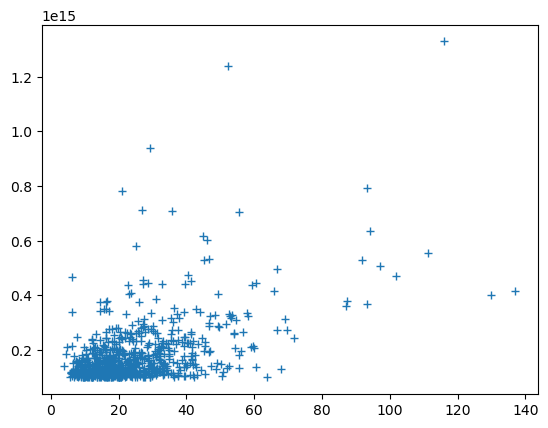

In [289]:
plt.errorbar(c_merged['richness'],c_merged['mass'], marker = '+', linestyle = 'None')

Text(0, 0.5, 'dec')

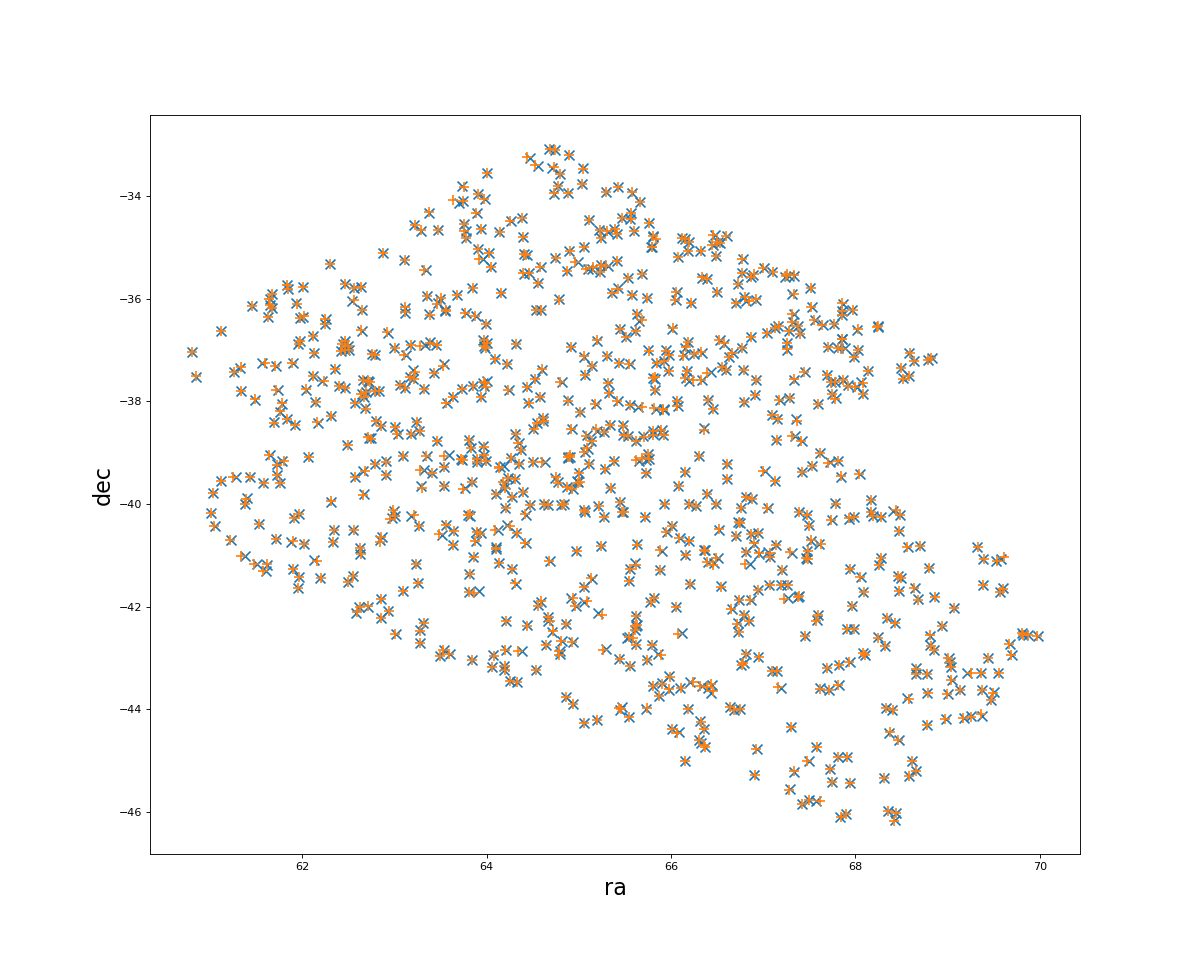

In [180]:
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=80)
plt.scatter(mt1['ra'], mt1['dec'], s=80, marker = 'x')
plt.scatter(mt2['ra'], mt2['dec'], s=80, marker = '+')
plt.xlabel('ra', fontsize = 20)
plt.ylabel('dec', fontsize = 20)

In [181]:
"""
%matplotlib widget 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
scatter = ax.scatter3D(mt1['ra'], mt1['z'], mt1['dec'], marker = 'x',s = 40)#c=mt1['z'], cmap='coolwarm')
scatter2 = ax.scatter3D(mt2['ra'], mt2['z'], mt2['dec'], marker = 'x',s=40)#c=mt2['z'], cmap='coolwarm')
#plt.colorbar(scatter)
#plt.colorbar(scatter2)
plt.title("simple 3D scatter plot")
plt.show()
"""

'\n%matplotlib widget \nfig = plt.figure(figsize = (10, 7))\nax = plt.axes(projection ="3d")\n# Creating plot\nscatter = ax.scatter3D(mt1[\'ra\'], mt1[\'z\'], mt1[\'dec\'], marker = \'x\',s = 40)#c=mt1[\'z\'], cmap=\'coolwarm\')\nscatter2 = ax.scatter3D(mt2[\'ra\'], mt2[\'z\'], mt2[\'dec\'], marker = \'x\',s=40)#c=mt2[\'z\'], cmap=\'coolwarm\')\n#plt.colorbar(scatter)\n#plt.colorbar(scatter2)\nplt.title("simple 3D scatter plot")\nplt.show()\n'

In [182]:
#Trying to plot completness naive way
comp = len(mt1)/len(cdc)
print(comp)

0.7996108949416343


In [190]:
#plotting completness in redshift bins
print(max(mt1['z']))
print(max(cdc['z']))

1.3026434666439588
2.662651343981759


In [191]:
z_bins = np.linspace(0,max(mt1['z']),10)

In [214]:
comp_l = []
z_l = []
for i in range(1, len(z_bins)):
    cdc1 = cdc[(cdc['z']<z_bins[i-1]) * (cdc['z']<z_bins[i-1])]
    mt11 = mt1[(mt1['z']<z_bins[i-1]) * (mt1['z']<z_bins[i-1])]
    if len(cdc1) != 0:
        comp_l.append(len(mt11)/len(cdc1))
    else : 
        comp_l.append(1)
    z_l.append((z_bins[i-1]+z_bins[i])/2)

In [218]:
print(z_l, comp_l)

[0.07236908148021994, 0.21710724444065982, 0.3618454074010997, 0.5065835703615396, 0.6513217333219794, 0.7960598962824192, 0.9407980592428592, 1.0855362222032992, 1.2302743851637388] [1, 1.0, 0.9642857142857143, 0.9547738693467337, 0.96398891966759, 0.9567779960707269, 0.9453717754172989, 0.937984496124031, 0.9322429906542056]


Text(0, 0.5, 'redshift')

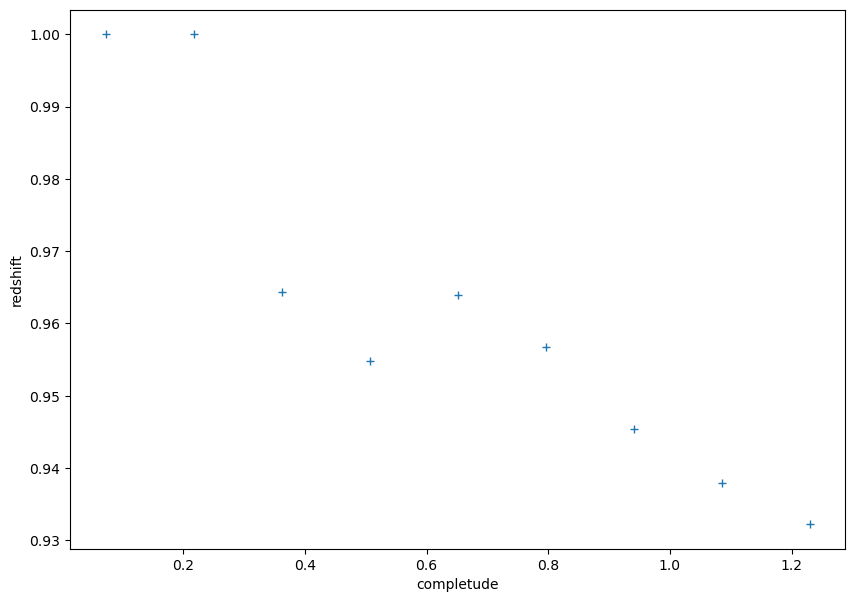

In [217]:
fig = plt.figure(figsize = (10, 7))
plt.errorbar(z_l, comp_l, marker = '+', linestyle = 'None')
plt.xlabel('redshift')
plt.ylabel('compltetude')

In [156]:
len(cdc[cdc['z']<1.5])

956